In [2]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# --------------------------
# Dataset Definition
# --------------------------
from sklearn.preprocessing import StandardScaler

class BatteryDataset(Dataset):
    def __init__(self, pkl_paths):
        self.paths = pkl_paths
        self.scaler = StandardScaler()

        # 모든 데이터를 flatten 후 fit (학습셋에 대해서만)
        all_data = []
        for path in self.paths:
            x = torch.load(path, weights_only=False)[0]
            all_data.append(x)
        all_data = np.concatenate(all_data, axis=0)
        self.scaler.fit(all_data)
        
    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        data = torch.load(path, weights_only=False)
        x = data[0]
        x = self.scaler.transform(x)
        x = torch.tensor(x, dtype=torch.float32)
        label_raw = float(data[1]['label'])
        label = 1.0 if label_raw == 10.0 else 0.0
        y = torch.tensor(label, dtype=torch.float32)
        return x, y


In [3]:
class BatteryTestDataset(Dataset):
    def __init__(self, pkl_paths, scaler):
        self.paths = pkl_paths
        self.scaler = scaler

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        data = torch.load(path, weights_only=False)
        x = data[0]
        x = self.scaler.transform(x)
        x = torch.tensor(x, dtype=torch.float32)
        label_raw = float(data[1]['label'])
        label = 1.0 if label_raw == 10.0 else 0.0
        y = torch.tensor(label, dtype=torch.float32)
        return x, y


In [4]:
# --------------------------
# LSTM Model
# --------------------------
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim=8, hidden_dim=64, num_layers=2):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # 마지막 타임스텝
        return out.squeeze(1)

In [5]:

# --------------------------
# Prepare Data
# --------------------------
train_paths = glob('./dataset/battery_brand3/train/*.pkl')
test_paths = glob('./dataset/battery_brand3/test/*.pkl')

# 클래스별 비율
normal_count = sum(int(torch.load(p)[1]['label']) == 0 for p in train_paths)
abnormal_count = sum(int(torch.load(p)[1]['label']) == 10 for p in train_paths)
pos_weight = torch.tensor([normal_count / abnormal_count])

train_dataset = BatteryDataset(train_paths)
test_dataset = BatteryTestDataset(test_paths,  scaler=train_dataset.scaler)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=512,  pin_memory=True)

/tmp/ipykernel_2048398/1805973455.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  normal_count = sum(int(torch.load(p)[1]['label']) == 0 for p in train_paths)
/tmp/ipyke

In [6]:
X_batch, y_batch = next(iter(train_loader))
print("y 라벨 샘플:", y_batch[:10])
print("y 데이터 타입:", y_batch.dtype)
print("y 고유 값들:", y_batch.unique())

y 라벨 샘플: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
y 데이터 타입: torch.float32
y 고유 값들: tensor([0., 1.])


In [17]:

# --------------------------
# Training Loop
# --------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMClassifier().to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3, verbose=True
)

num_epochs = 25
loss_history = []

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [13]:
device

device(type='cuda')

In [18]:
from sklearn.metrics import accuracy_score

for epoch in tqdm(range(num_epochs)):
    model.train()
    epoch_loss = 0
    all_preds = []
    all_labels = []

    for X, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(X).to(device)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * X.size(0)

        # accuracy 계산을 위한 예측 결과 수집
        preds = torch.sigmoid(logits) > 0.5
        all_preds.extend(preds.detach().cpu().numpy())
        all_labels.extend(y.detach().cpu().numpy())

    avg_loss = epoch_loss / len(train_loader.dataset)
    train_acc = accuracy_score(all_labels, all_preds)
    loss_history.append(avg_loss)
    scheduler.step(avg_loss)

    print(f"[Epoch {epoch+1:02d}] Average Loss: {avg_loss:.4f} | Train Accuracy: {train_acc:.4f}")


  4%|▍         | 1/25 [00:09<03:47,  9.50s/it]

[Epoch 01] Average Loss: 1.2932 | Train Accuracy: 0.8546


  8%|▊         | 2/25 [00:19<03:40,  9.57s/it]

[Epoch 02] Average Loss: 1.2280 | Train Accuracy: 0.6522


 12%|█▏        | 3/25 [00:29<03:34,  9.74s/it]

[Epoch 03] Average Loss: 1.0240 | Train Accuracy: 0.6727


 16%|█▌        | 4/25 [00:38<03:21,  9.60s/it]

[Epoch 04] Average Loss: 0.7615 | Train Accuracy: 0.7684


 20%|██        | 5/25 [00:47<03:08,  9.44s/it]

[Epoch 05] Average Loss: 0.6599 | Train Accuracy: 0.7941


 24%|██▍       | 6/25 [00:56<02:57,  9.35s/it]

[Epoch 06] Average Loss: 0.6483 | Train Accuracy: 0.7767


 28%|██▊       | 7/25 [01:05<02:47,  9.29s/it]

[Epoch 07] Average Loss: 0.6371 | Train Accuracy: 0.7859


 32%|███▏      | 8/25 [01:15<02:38,  9.30s/it]

[Epoch 08] Average Loss: 0.6294 | Train Accuracy: 0.7917


 36%|███▌      | 9/25 [01:24<02:28,  9.29s/it]

[Epoch 09] Average Loss: 0.6327 | Train Accuracy: 0.7835


 40%|████      | 10/25 [01:33<02:19,  9.28s/it]

[Epoch 10] Average Loss: 0.6275 | Train Accuracy: 0.7739


 44%|████▍     | 11/25 [01:43<02:11,  9.41s/it]

[Epoch 11] Average Loss: 0.6215 | Train Accuracy: 0.7712


 48%|████▊     | 12/25 [01:53<02:03,  9.52s/it]

[Epoch 12] Average Loss: 0.6075 | Train Accuracy: 0.7821


 52%|█████▏    | 13/25 [02:02<01:53,  9.48s/it]

[Epoch 13] Average Loss: 0.6031 | Train Accuracy: 0.7881


 56%|█████▌    | 14/25 [02:11<01:42,  9.36s/it]

[Epoch 14] Average Loss: 0.6095 | Train Accuracy: 0.7966


 60%|██████    | 15/25 [02:21<01:33,  9.39s/it]

[Epoch 15] Average Loss: 0.6041 | Train Accuracy: 0.7882


 64%|██████▍   | 16/25 [02:30<01:25,  9.45s/it]

[Epoch 16] Average Loss: 0.5913 | Train Accuracy: 0.7950


 68%|██████▊   | 17/25 [02:40<01:15,  9.43s/it]

[Epoch 17] Average Loss: 0.5948 | Train Accuracy: 0.7910


 72%|███████▏  | 18/25 [02:49<01:05,  9.36s/it]

[Epoch 18] Average Loss: 0.5877 | Train Accuracy: 0.7935


 76%|███████▌  | 19/25 [02:58<00:56,  9.36s/it]

[Epoch 19] Average Loss: 0.5859 | Train Accuracy: 0.7959


 80%|████████  | 20/25 [03:07<00:46,  9.33s/it]

[Epoch 20] Average Loss: 0.5887 | Train Accuracy: 0.8047


 84%|████████▍ | 21/25 [03:17<00:37,  9.36s/it]

[Epoch 21] Average Loss: 0.5835 | Train Accuracy: 0.8003


 88%|████████▊ | 22/25 [03:27<00:28,  9.45s/it]

[Epoch 22] Average Loss: 0.5959 | Train Accuracy: 0.7906


 92%|█████████▏| 23/25 [03:36<00:19,  9.53s/it]

[Epoch 23] Average Loss: 0.5790 | Train Accuracy: 0.8014


 96%|█████████▌| 24/25 [03:46<00:09,  9.52s/it]

[Epoch 24] Average Loss: 0.5811 | Train Accuracy: 0.8110


100%|██████████| 25/25 [03:56<00:00,  9.45s/it]

[Epoch 25] Average Loss: 0.5777 | Train Accuracy: 0.8021


In [ ]:
num_epochs= 20
for epoch in tqdm(range(num_epochs)):
    model.train()
    epoch_loss = 0
    all_preds = []
    all_labels = []

    for X, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(X).to(device)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * X.size(0)

        # accuracy 계산을 위한 예측 결과 수집
        preds = torch.sigmoid(logits) > 0.5
        all_preds.extend(preds.detach().cpu().numpy())
        all_labels.extend(y.detach().cpu().numpy())

    avg_loss = epoch_loss / len(train_loader.dataset)
    train_acc = accuracy_score(all_labels, all_preds)
    loss_history.append(avg_loss)
    scheduler.step(avg_loss)

    print(f"[Epoch {epoch+1:02d}] Average Loss: {avg_loss:.4f} | Train Accuracy: {train_acc:.4f}")

  5%|▌         | 1/20 [00:09<02:56,  9.29s/it]

[Epoch 01] Average Loss: 0.5981 | Train Accuracy: 0.8045


 10%|█         | 2/20 [00:18<02:46,  9.27s/it]

[Epoch 02] Average Loss: 0.5738 | Train Accuracy: 0.7994


 15%|█▌        | 3/20 [00:27<02:37,  9.26s/it]

[Epoch 03] Average Loss: 0.5717 | Train Accuracy: 0.8009


 20%|██        | 4/20 [00:36<02:25,  9.10s/it]

[Epoch 04] Average Loss: 0.5716 | Train Accuracy: 0.7872


 25%|██▌       | 5/20 [00:45<02:16,  9.12s/it]

[Epoch 05] Average Loss: 0.5691 | Train Accuracy: 0.7933


 30%|███       | 6/20 [00:54<02:07,  9.11s/it]

[Epoch 06] Average Loss: 0.5661 | Train Accuracy: 0.7967


 35%|███▌      | 7/20 [01:04<01:59,  9.21s/it]

[Epoch 07] Average Loss: 0.5703 | Train Accuracy: 0.8009


 40%|████      | 8/20 [01:13<01:49,  9.16s/it]

[Epoch 08] Average Loss: 0.5638 | Train Accuracy: 0.7934


 45%|████▌     | 9/20 [01:22<01:39,  9.04s/it]

[Epoch 09] Average Loss: 0.5588 | Train Accuracy: 0.7980


 50%|█████     | 10/20 [01:31<01:29,  9.00s/it]

[Epoch 10] Average Loss: 0.5641 | Train Accuracy: 0.7956


 55%|█████▌    | 11/20 [01:40<01:21,  9.09s/it]

[Epoch 11] Average Loss: 0.5570 | Train Accuracy: 0.7973


 60%|██████    | 12/20 [01:49<01:13,  9.18s/it]

[Epoch 12] Average Loss: 0.5553 | Train Accuracy: 0.7986


 65%|██████▌   | 13/20 [01:58<01:03,  9.09s/it]

[Epoch 13] Average Loss: 0.5558 | Train Accuracy: 0.8005


 70%|███████   | 14/20 [02:08<00:55,  9.24s/it]

[Epoch 14] Average Loss: 0.5635 | Train Accuracy: 0.8016


 75%|███████▌  | 15/20 [02:17<00:46,  9.22s/it]

[Epoch 15] Average Loss: 0.5565 | Train Accuracy: 0.7964


 80%|████████  | 16/20 [02:27<00:37,  9.42s/it]

[Epoch 16] Average Loss: 0.5660 | Train Accuracy: 0.7998


 85%|████████▌ | 17/20 [02:36<00:27,  9.29s/it]

[Epoch 17] Average Loss: 0.5680 | Train Accuracy: 0.8008


 90%|█████████ | 18/20 [02:45<00:18,  9.28s/it]

[Epoch 18] Average Loss: 0.5627 | Train Accuracy: 0.8016


 95%|█████████▌| 19/20 [02:54<00:09,  9.24s/it]

[Epoch 19] Average Loss: 0.5527 | Train Accuracy: 0.7977


100%|██████████| 20/20 [03:03<00:00,  9.18s/it]

[Epoch 20] Average Loss: 0.5556 | Train Accuracy: 0.7976


In [28]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch

def evaluate_model(model, test_loader, device, threshold=0.8):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X, y in test_loader:
            X = X.to(device)
            y = y.to(device).float()

            logits = model(X)
            probs = torch.sigmoid(logits)
            preds = (probs >= threshold).long()

            all_preds.extend(preds.cpu().numpy().astype(int))
            all_labels.extend(y.cpu().numpy().astype(int))


    # 📊 스코어 계산
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='binary')
    cm = confusion_matrix(all_labels, all_preds)

    print(f"✅ Accuracy: {acc:.4f}")
    print(f"✅ F1 Score: {f1:.4f}")
    print(f"📊 Confusion Matrix:\n{cm}")

    # 📈 시각화
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=["Normal", "Abnormal"], yticklabels=["Normal", "Abnormal"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()


✅ Accuracy: 0.8373
✅ F1 Score: 0.4258
📊 Confusion Matrix:
[[3824  723]
 [  78  297]]


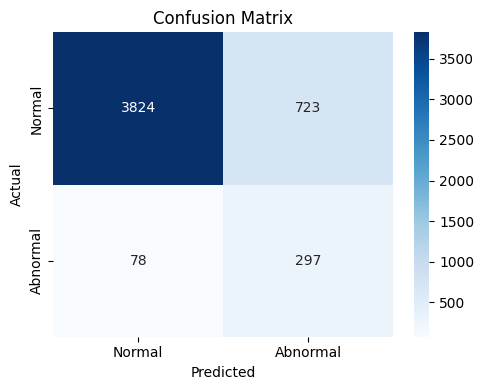

In [36]:
evaluate_model(model, test_loader, device, threshold=0.80)

In [24]:
X_batch, y_batch = next(iter(train_loader))
print("y 라벨 샘플:", y_batch[:10])
print("y 데이터 타입:", y_batch.dtype)
print("y 고유 값들:", y_batch.unique())

y 라벨 샘플: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
y 데이터 타입: torch.float32
y 고유 값들: tensor([0., 1.])


In [22]:

# --------------------------
# Save Model & Hyperparameters
# --------------------------
os.makedirs('./saved_models', exist_ok=True)
torch.save(model.state_dict(), './saved_models/lstm_brand3.pt')
torch.save({
    'input_dim': 8,
    'hidden_dim': 64,
    'num_layers': 2,
    'pos_weight': pos_weight.item(),
    'lr': 1e-2,
    'batch_size': 512,
    'epochs': num_epochs,
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(), 
}, './saved_models/lstm_brand3_hparams.pt')


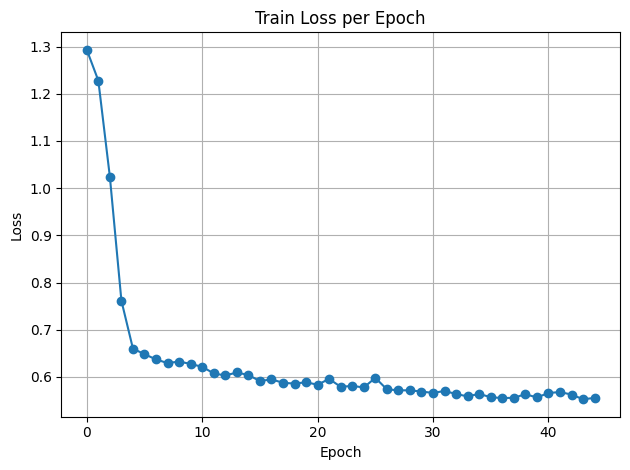

In [23]:

# --------------------------
# Plot Loss History
# --------------------------
plt.plot(loss_history, marker='o')
plt.title("Train Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()
